## Trabajo Práctico N°1

*Introducción*

Analizar el dataset con datos del primer semestre del 2017 de la inmobiliaria properatti.
Este primer paso deberá servir para poder realizar modelos de predicción utilizando regresiones.

*Objetivos:*


1.- Efectuar una limpieza del dataset provisto. Particularmente, deberá diseñar estrategias para lidiar con los datos perdidos en ciertas variables.

2-  Realizar un análisis descriptivo de las principales variables.

3.- Crear nuevas columnas a partir de las características dadas que puedan tener valor predictivo.


## Inicio
**Importación de librerías**<br>

In [1]:
#Importo las librerias que deseo usar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set(color_codes=True)
import numpy as np
#pd.options.display.max_rows = 100
%matplotlib inline

Definición de algunas funciones a utilizar en la notebook para la limieza del dataset

**Datos del dataframe**<br>
Esta función me ayuda a ver como esta constituido el dataframe mostrandolo de una manera más 
didáctica. Me muestra la cantidad de registros,cuantos son nulos, cuantos no nulos, su porcentaje y el tipo de datos

In [2]:
def datos_df(df):
        
    # Cantidad total de registros
    cant_registros = len(df)

    # Creo un dataframe para mostrar la estructura del set de datos

    valores_df = pd.DataFrame(columns=['No Nulos','Nulos','% Nulos','Tipo'])

    # Por cada columna
    for columna in df.columns:
        
        # Cantidad de Valores nulos
        val_no_null = df[columna].notnull().sum()
        
        # Cantidad de Valores nulos
        val_null = df[columna].isnull().sum()
        
        # Porcentaje de Valores Nulos en el dataset
        porcentaje_null = val_null / cant_registros * 100
        
        # El tipo de dato de la columna
        tipo_dato = df[columna].dtype
        
        # Agrego la fila al dataframe
        valores_df.loc[columna] = [val_no_null,val_null, porcentaje_null, tipo_dato]
    
    # Ordeno los valores por % de nulos de menor a mayor
    return valores_df.sort_values(by='% Nulos', ascending=True)

## Importo el dataset

In [3]:
#importo el archivo de properati
properatti = pd.read_csv("properatti.csv")

1. Realizo un primer análisis viendo la estructura del dataframe con la función **datos_df**
    + Tomo las columnas que me interesan para este primer análisis según lo que indica el enunciado.
    + Luego cambio el nombre de las columnas para hacerlo más didactico.

In [4]:
datos_df(properatti)

,No Nulos,Nulos,% Nulos,Tipo
Unnamed: 0,121220,0,0.000000,int64
operation,121220,0,0.000000,object
property_type,121220,0,0.000000,object
place_with_parent_names,121220,0,0.000000,object
country_name,121220,0,0.000000,object
state_name,121220,0,0.000000,object
properati_url,121220,0,0.000000,object
title,121220,0,0.000000,object
description,121218,2,0.001650,object
place_name,121197,23,0.018974,object


In [5]:
#tomo solo las columnas que podrían llegar a darme ciertas features interesentas para el análisis

df=pd.DataFrame(properatti,columns=['property_type','place_name','place_with_parent_names','state_name','lat','lon','price','currency','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','expenses','description','title'])

#Ahora cambio el nombre de los campos para hacerlo más didactico

df.columns=['tipo_propiedad','localidad_barrio','ubicacion_completa','provincia_distrito','lat','lon','precio','moneda','precio_aprox_ars','precio_aprox_usd','total_m2','m2_cubiertos','precio_usd_por_m2','precio_por_m2','piso','habitaciones','expensas','descripcion','titulo']

***Aclaración sobre los nombres del los campos***<br>
Por el tamaño del dataset y como herramienta de exploración se utilizo el excel. Esto entendiendo que el trabajo de análisis puede realizarse con cualquier herramienta que se ajuste mejor a dicho fin en base al conocimiento del alumno.

En función de lo anterior se pudo ver:
1. Mejorar el nombre de los campos
2. Se define el campo **localidad_barrio** porque según la estructura ese campo solo posee los valores referentes a localidades de grandes Distritos o barrios dentro de las localidades por ejemplo Capital Federal.
3. Se define el campo **provincia_distrito** porque según la estructura ese campo solo posee los valores referentes a grandes distritos/departamentos y provincias.
4. En base al campo **provincia_distrito** generamos un dataset con esos valores, la división por zona del país y la latitud y longuitud de los centroides de cada zona. Creo que esta información luego nos puede llegar a servir para mostrar los datos. 

In [6]:
#importo el dataset con la zona y los centroides según la provincia_distrito y luego hago un inner join en un nuevo dataset
prov_distr=pd.read_csv("centroides_provincias.csv")
df1=pd.merge(df, prov_distr, how='outer', on='provincia_distrito')

## Comenzando con algo de limpieza

***Posibles features que definen el precio/precio por m2 de una propiedad***

**tipo_propiedad ; localidad_barrio ; provincia_distrito ; total_m2 ; superficie_cubierta_m2 ; habitaciones ; piso**

1. Voy a tratar de llenar los 23 nulos de localidad_barrio tratando de sacar dicho valor de ubicacion_completa o de algún campo texto como descripcion o título
2. Voy pasar todo el precio de las propiedades a dólares.
3. Voy a analizar los valores de precios por metro cuadrado. Y para este caso solo voy a usar el campo **precio_usd_por_m2** completando los faltatantes usando el campo **precio_por_m2** para normalizar.



In [7]:
#Veo si puedo completar los valores nulos de localidad_barrio usando el campo ubicación_completa
df1.loc[(df1.localidad_barrio.isnull()), 'ubicacion_completa']

58500    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
59171    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
59430    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
60189    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
61048    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
61817    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
62207    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
62356    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
65678    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
67181    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
67472    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
68773    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
69585    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
69999    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
70021    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
70024    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
70039    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
70144    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
70168    |Argentina|Bs.As. G.B.A. Zona Norte|T

Se puede ver que no dispongo de ese valor voy a utilizar los campos **titulo** y **descripcion**

Luego de analizar el campo titulo se puede ver que el nombre del barrio corresponde a Barrio Privado Santa Maria para la mayoría de los casos, Barrio El Palmar, Barrio Las Tipas y Barrio Privado La Alameda. 

Para poder detectar esos casos se utlizó el código comentado que esta abajo en donde se tuvieron que ver las 23 celdas del campo **titulo** y **descripcion**.

In [8]:
#Veo que información puedo sacar con titulo y descripcion para los casos nulos de localidad_barrio
#df1.loc[df1.localidad_barrio.isnull(),['titulo','descripcion']]

#recupero el DataFrame y veo en titulo lo que contenga el nombre del Barrio SANTA MARIA solo recupero 15 y son 23
#df1.loc[(df1['titulo'].str.\
#contains('SANTA MARIA|Santa Ma', case=False,regex=True)) & df1.localidad_barrio.isnull(),['localidad_barrio','ubicacion_completa','descripcion','titulo']]

#agrego en localidad barrio Santa María- es un barrio cerrado según lo buscado en internet
df1.loc[(df1['titulo'].str.\
contains('SANTA MARIA|Santa Ma', case=False)) & df1.localidad_barrio.isnull(),'localidad_barrio']='Barrio Privado Santa Maria'

#ahora completo a mano usando el indice, con la función de arriba saque los nulos que me quedan
df1.iloc[38856,1]="Barrio Privado Santa Maria"
df1.iloc[45970,1]="Barrio El Palmar"
df1.iloc[53130,1]="Barrio Privado Santa Maria"
df1.iloc[62411,1]="Barrio Las Tipas"
df1.iloc[62413,1]="Barrio Privado Santa Maria"
df1.iloc[18622,1]="Barrio Privado Santa Maria"
df1.iloc[46642,1]="Barrio Privado Santa Maria"
df1.iloc[63849,1]="Barrio Privado La Alameda"

In [9]:
#normalizo el precio de la moneda modificando los casos de precio en donde la moneda es pesos
#los valores en pesos los llevo al promedio del dolar en el primer semestre 2017
#primero verifico la cantidad de monedas disponibles

df1.groupby('moneda')['moneda'].count()

moneda
ARS    13219
PEN        2
USD    87587
UYU        1
Name: moneda, dtype: int64

In [10]:
#El promedio de 16,1 valor al 1/2/2017 y 16,8 al 30/6/2017 = 16,45
#PEN es sol peruano y UYU es uruguayo viendo estos valores con una consulta usando loc se puede
#ver que PEN y UYU son errores así que para esos casos uso el precio_aprox_usd
df1.loc[df1.moneda=='ARS','precio']=df1.loc[df1.moneda=='ARS','precio'] / 16.45

In [11]:
#lo chequee y tenia precio aproximado en USD entiendo es un error de dato
df1.loc[df1.moneda=='PEN','precio']=df1.loc[df1.moneda=='PEN','precio_aprox_usd']

In [12]:
#lo mismo que el punto anterior
df1.loc[df1.moneda=='UYU','precio']=df1.loc[df1.moneda=='UYU','precio_aprox_usd']

In [13]:
#ahora completo el precio_usd_por_m2 con el precio_por_m2 convertido a USD para los casos en donde
#el precio_por_m2 no es nulo y precio_usd_por_m2 es nulo
df1.loc[(df1.precio_por_m2.notnull()) & (df1.precio_usd_por_m2.isnull()),'precio_usd_por_m2']=df1.loc[(df1.precio_por_m2.notnull()) & (df1.precio_usd_por_m2.isnull()),'precio_por_m2']

In [14]:
#Ahora para los casos en donde la moneda local es ARS hago el cambio
df1.loc[df1.moneda=='ARS','precio_usd_por_m2']=df1.loc[df1.moneda=='ARS','precio_usd_por_m2'] / 16.45

In [15]:
#cambio los nombres de los tipos de moneda a USD
df1.loc[((df1.moneda=='ARS') | (df1.moneda=='UYU') | (df1.moneda=='PEN')),'moneda']="USD"

In [16]:
#verifico
df1.groupby('moneda')['moneda'].count()

moneda
USD    100809
Name: moneda, dtype: int64

In [17]:
#Los casos en donde precio_usd_por_m2== precio agrego null al precio_usd_por_m2 y al precio_por_m2
#para luego ver si lo puedo llenar con la media
df1.loc[(df1.precio_usd_por_m2==df1.precio),'precio_usd_por_m2'] = np.nan

## Comienzo con algo de análisis de datos
Veo como están correlacionados las variables que propongo con el precio.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

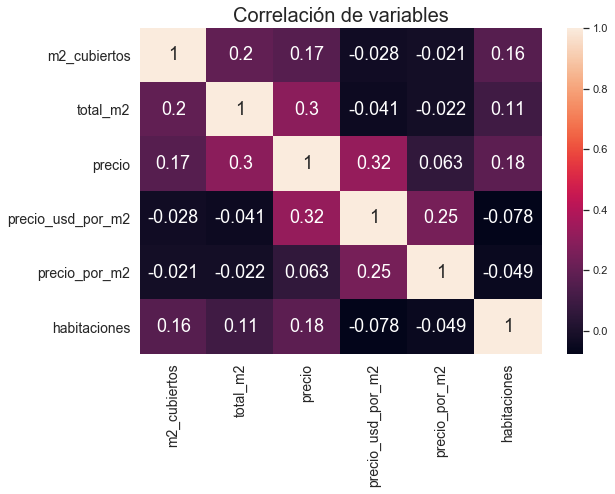

In [18]:
plt.figure(figsize=(9,6))
sns.heatmap(df1[['m2_cubiertos','total_m2','precio','precio_usd_por_m2','precio_por_m2','habitaciones']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Correlación de variables', fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

**Observaciones:**
1. Podemos ver que la correlación más fuerte se da entre el precio y el total de metros cubiertos, campos **precio** y **total_m2**

En función de ello vamos a tratar de completar los valores nulos del campo total_m2 sacando los valores de la descripción usando una expresión regular.

2. Hay algo de correlación con las habitaciones vamos a tratar de hacer lo mismo que en el punto 1
3. Vamos a eliminar outliers en precio_usd_por_m2 usando el criterio del 3 cuartil 
4. Luego vamos a completar con la media los valores de precio_usd_por_m2 
5. En función de la correlación vamos a crear una columna que sea precio/precio_usd_por_m2 para ver que relación hay con la supercie total -**total_m2** - 
6. Por otro lado hay una correlación negativa entre precio_usd_por_m2 y m2_cubiertos. Vamos a crear luego una columna con el valor de precio por metro cubierto. Para ver si mejora esa variable con la relación precio.

In [19]:
#Creo la mask para obtener los registros con superficie cubierta el null o en 0
mask = (df1.total_m2.isnull()) | (df1.total_m2 == 0)

# Obtengo las superficies de la descripción usando una regex googleada y mirando la descripción con 
# una consulta similar al caso de localidad_barrio
# esta expresión me devuelve un dataframe de 12 columnas en donde la primera posee el valor con mts o m2
tmp = df1.loc[mask,'descripcion'].str.lower().str.extract('(((\d+)|(\d+(,|\.)\d+))(\s+|())mts|((\d+)|(\d+(,|\.)\d+))(\s+|())m2)', expand=False)

#Ahora completo los valores obtenidos en el dataframe original
#df1.loc[mask,['total_m2']] = tmp[0].str.lower().str.replace('m2','').str.replace('mts','')

In [20]:
#tmp.groupby(0)[0].count().sort_index()
#tmp.loc[tmp[0]=='1.000 mts']
#df1.iloc[56507,17]

Verificando algunos valores desisto de usar la función para completar debido a la gran variedad de valores que arroja. Los mismos no necesariamente cubren la superficie total.

In [21]:
#Primero lo más fácil asigno 1 a las propiedades que en su descripción tengan la palabra monoambiente
df1.loc[(df1['habitaciones'].isnull()) & (df1['descripcion'].str.lower().str.contains('monoambiente')),'habitaciones'] = 1

# Ahora obtengo los ambientes mediante la descripcion
#tmp = df1.loc[(df1['habitaciones'].isnull()),'descripcion'].str.lower().str.extract("(\d+)(\s|())amb", expand=False)

#tmp.groupby(0)[0].count()

#tmp.groupby(0)[0].count().sort_index()
#tmp.loc[tmp[0]=='072']
#df1.iloc[8892,17]

# Asigno la cantidad de ambientes, al dataset original donde habitaciones es null
#df1.loc[dataframe['habitaciones'].isnull(),'habitaciones'] = tmp[0]

Verificando algunos valores desisto de usar la función para completar debido a la gran variedad de valores que arroja. Los mismos no necesariamente corresponden a la cantidad de ambientes.

Para eliminar outliers utilizo el criterio del 3 cuartil El criterio de mayor que el tercer cuartil más 1.5 veces el rango intercuartil o menor que el primer cuartil menos 1.5 veces el rango intercuartil surge de la distribución normal. 
En esa distribución el 99.7% de la población se encuentra en el rango definido por la media (poblacional) más menos 3 veces el desvío estándar (poblacional). Para tomar un criterio voy a 
pedir que n sea > 20 por tipo_propiedad, provincia_distrito y localidad_barrio

In [22]:
#1.- Armo un DataFrame con el tipo de propiedad, barrios y su std
tmp_out1=pd.DataFrame(df1.groupby(['tipo_propiedad','provincia_distrito','localidad_barrio'])['precio_usd_por_m2'].describe(), columns=['count','std'])

tmp_out1['stdx3']=tmp_out1.loc[:,['std']]*3
tmp_out1['-stdx3']=tmp_out1.loc[:,['std']]/3

#3.- hago un outer join contra la tabla df1 para obtener un nuevo dataframe con los campos stdx3, -stdx3 y count 
# para poder comparar y luego eliminar los casos en donde el precio_usd_por_m2 es mayor a 3std o menor
# Voy a usar un n dado por count para no eliminar muchos casos o no?

df2=pd.merge(df1, tmp_out1, how='left', left_on=['tipo_propiedad','provincia_distrito','localidad_barrio'], right_index=True)

#4.- Genero una nueva columna en df2 llamada elimar_por_std para usarla luego para descartar los casos en 1
df2['eliminar_por_std']= pd.Series(np.nan, index=df2.index) 

#df2.loc[(df2['precio_usd_por_m2']>df2['stdx3']) & (df2['precio_usd_por_m2'].notnull()) & (df2['count']>20),'eliminar_por_std']=1
df2.loc[(df2['precio_usd_por_m2']>df2['stdx3']) & (df2['precio_usd_por_m2'].notnull()),'eliminar_por_std']=1

#df2.loc[(df2['precio_usd_por_m2']<df2['-stdx3']) & (df2['precio_usd_por_m2'].notnull())& (df2['count']>20),'eliminar_por_std']=1
df2.loc[(df2['precio_usd_por_m2']<df2['-stdx3']) & (df2['precio_usd_por_m2'].notnull()),'eliminar_por_std']=1

df2.loc[df2.eliminar_por_std.isnull(),'eliminar_por_std']=0

#5.- Descarto los casos registros superiores a std x 3 y menores a std x 3, reescribo el DataFrame
df2=df2.loc[df2.eliminar_por_std==0]

**Imputando con la media**<br>
Lleno los datos del campos **precio_usd_por_m2** con la media, solo para los casos en donde este es nulo.
Luego descarto los casos en donde **precio_usd_por_m2** es nulo quedandome con un solo DataFrame.

Pero antes veo como están dispersos los valores de **precio_usd_por_m2** en función del **total_m2**

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


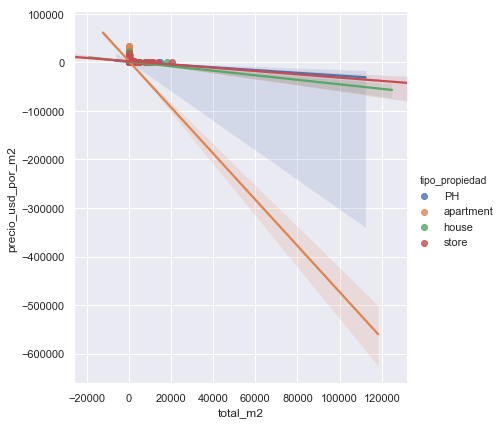

In [23]:
#plt.figure(figsize=(10, 8))
#plt.scatter(df2.loc[:, 'total_m2'], df2.loc[:,'precio_usd_por_m2'], c= 'g', marker='o',alpha = 0.5)

#plt.scatter(df2.loc[(df2.total_m2.notnull() & df2.precio.notnull()),'total_m2'], 
            #df2.loc[(df2.total_m2.notnull() & df2.precio.notnull()),'precio'], c= 'g', marker='o',alpha = 0.5)

#plt.grid(True)
#plt.xlabel('total_m2')
#plt.ylabel('precio_usd_por_m2')
#plt.title('precio_m2 vs total_m2');

g = sns.lmplot(x="total_m2", y="precio_usd_por_m2", data=df2, hue="tipo_propiedad", height=6)


En el gráfico anterior podemos ver como existe una correlación negativa entre el **total_m2 y el precio_usd_por_m2**. Según el tipo de propiedad

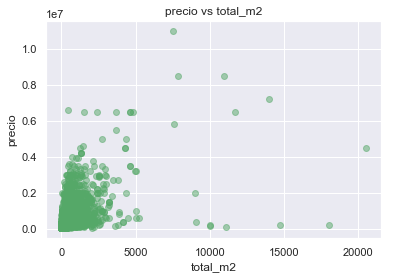

In [24]:
plt.scatter(df2.loc[:, 'total_m2'], df2.loc[:,'precio'], c= 'g', marker='o',alpha = 0.5)
plt.grid(True)
plt.xlabel('total_m2')
plt.ylabel('precio')
plt.title('precio vs total_m2');

En el gráfico anterior se puede ver como existen algunos outliers de precio 

In [25]:
#Armo un DataFrame con las medias
medias=pd.DataFrame(df2.groupby(['tipo_propiedad','provincia_distrito','localidad_barrio'])['precio_usd_por_m2'].mean())
medias.columns=['media']

#Hago el join con las medias calculadas 
df3=pd.merge(df2, medias, how='left', left_on=['tipo_propiedad','provincia_distrito','localidad_barrio'], right_index=True)

#Reemplazo con la media en donde precio_usd_por_m2 es nulo
df3.loc[df3.precio_usd_por_m2.isnull(),'precio_usd_por_m2']=df3.loc[df3.precio_usd_por_m2.isnull(),'media']

#Me quedo solo con los casos en donde el precio_usd_por_m2 no es nulo
df3=df3.loc[df3.precio_usd_por_m2.notnull()]

**Creando más columnas con posible valor predictivo**

Seguimos según lo planteado en los puntos 5 y 6. Luego realizamos un gráfico de correlación.

In [26]:
#creamos el campo coef_precio_div_precio_m2 usando el precio/precio_usd_por_m2 
df3['coef_precio_div_precio_m2']= df3['precio'] / df3['precio_usd_por_m2']

#creamos el campo precio_usd_por_m2_cubierto usando el m2_cubiertos/precio_usd_por_m2 
df3['precio_usd_por_m2_cubierto']= df3['m2_cubiertos'] / df3['precio_usd_por_m2']

In [27]:
#Ahora elimino algunas columnas que no aportan para este análisis y hacen molesta la manipulacion del DataFrame
#Elimino ubicacion_completa ; moneda ; precio_aprox_ars ; expensas ; piso ; precio_aprox_usd

df3 = df3.drop('ubicacion_completa', axis=1)
df3 = df3.drop('moneda', axis=1)
df3 = df3.drop('expensas', axis=1)
df3 = df3.drop('piso', axis=1)
df3 = df3.drop('precio_aprox_usd', axis=1)
df3 = df3.drop('precio_aprox_ars', axis=1)
df3 = df3.drop('precio_por_m2', axis=1)

In [28]:
datos_df(df3)

,No Nulos,Nulos,% Nulos,Tipo
tipo_propiedad,86825,0,0.000000,object
eliminar_por_std,86825,0,0.000000,float64
zona_pais,86825,0,0.000000,object
lon_centroide,86825,0,0.000000,float64
lat_centroide,86825,0,0.000000,float64
precio_usd_por_m2,86825,0,0.000000,float64
titulo,86825,0,0.000000,object
provincia_distrito,86825,0,0.000000,object
descripcion,86823,2,0.002303,object
count,86817,8,0.009214,float64


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

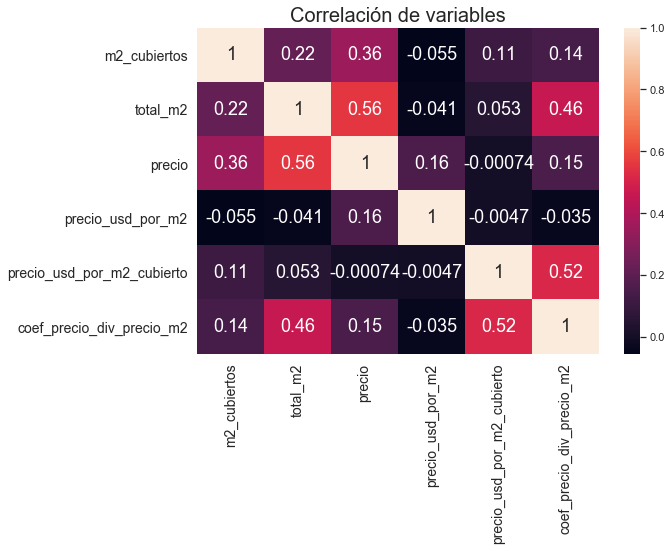

In [29]:
plt.figure(figsize=(9,6))
sns.heatmap(df3[['m2_cubiertos','total_m2','precio','precio_usd_por_m2','precio_usd_por_m2_cubierto','coef_precio_div_precio_m2']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Correlación de variables', fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

Podemos ver que mejora la correlación precio vs total de m2 y se refuerza con el coeficiente calculado como el precio/precio_usd_por_m2
También se nota evidente la correlación precio_usd_por_m2_cubierto siendo un calculo realizado a partir de los m2_cubiertos y el precio

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


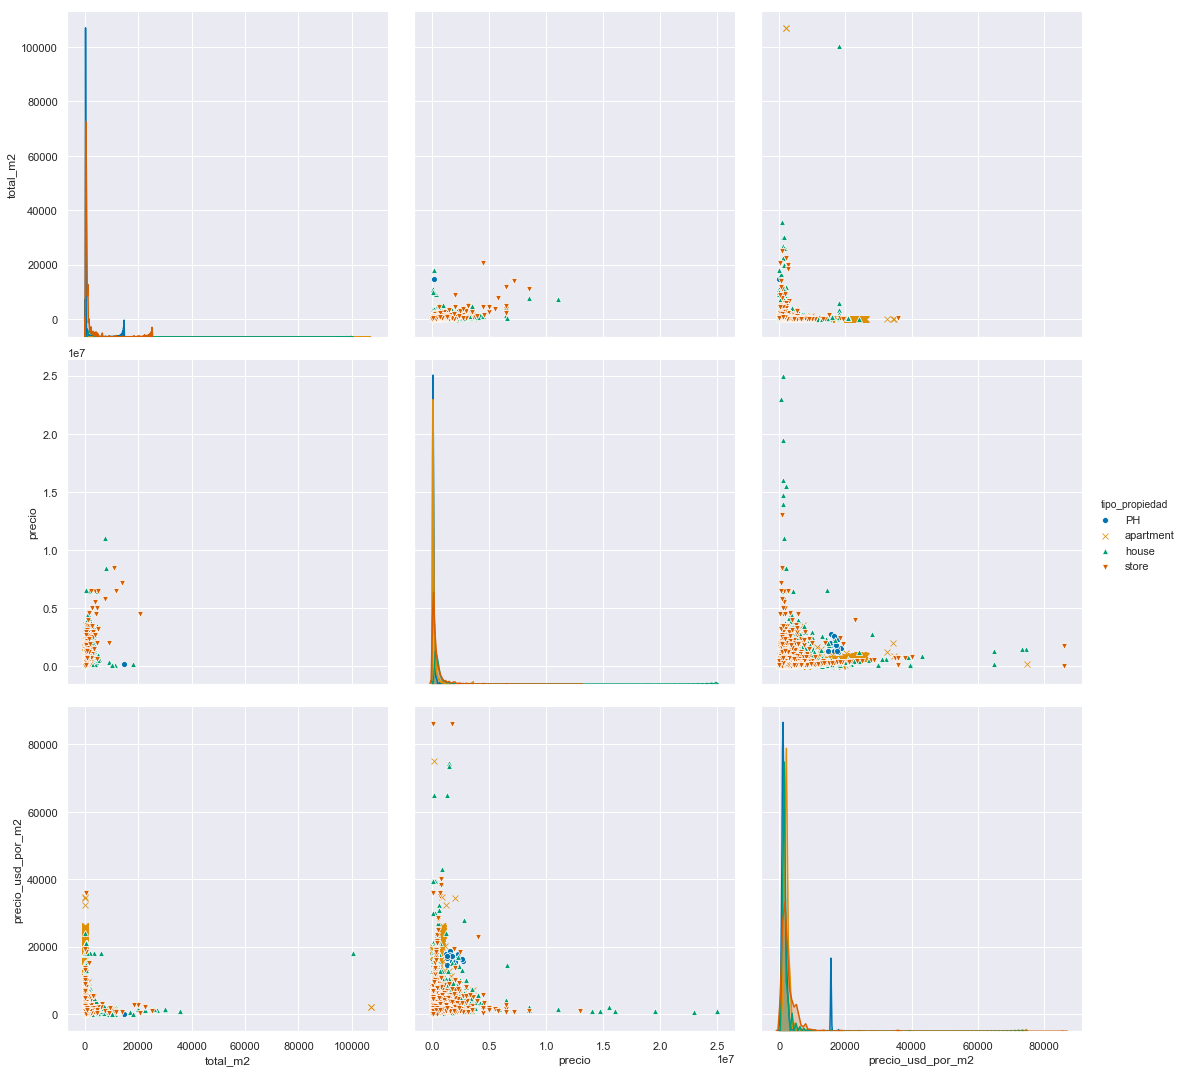

In [30]:
sns.pairplot(df3, vars=[c for c in ['total_m2','precio','precio_usd_por_m2']], hue="tipo_propiedad", 
             palette="colorblind", diag_kind="kde", height=5, markers=["o","x","^","v"]);

Usando las liberías de seaborn las relaciones de **precio, precio_usd_por_m2 y total_m2** según el tipo de propiedad.

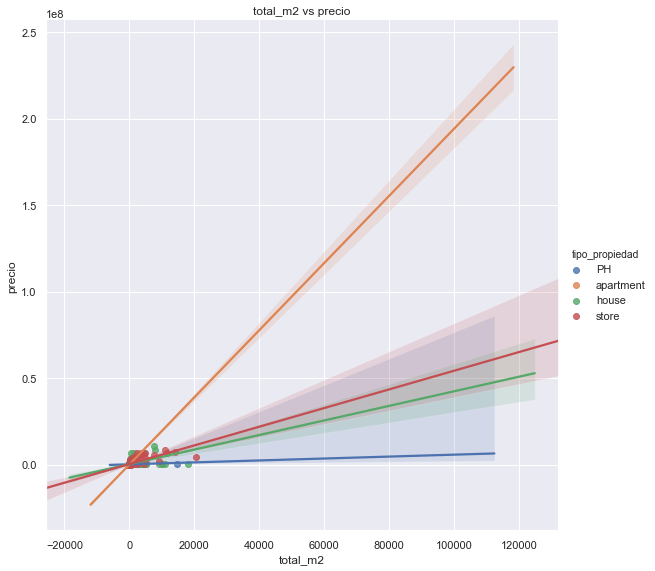

In [31]:
g = sns.lmplot(x="total_m2", y="precio", hue="tipo_propiedad",data=df3, height=8)
plt.title('total_m2 vs precio');

Con el gráfico anterior podemos ver la dispersión según el tipo de propiedad entre el precio y el total de m2. Aqui se pueden ver como es la correlación para cada caso. Entendemos que la relación se podría mantener para las zonas.

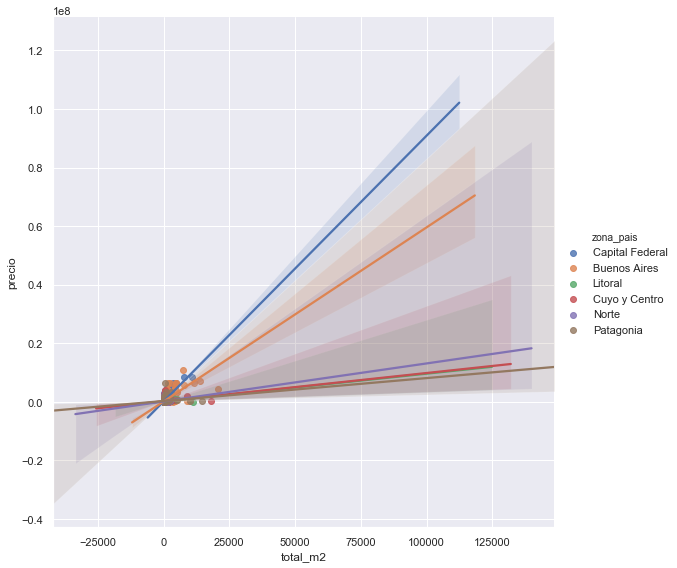

In [32]:
g = sns.lmplot(x="total_m2", y="precio", data=df3, hue='zona_pais' ,height=8)

Vemos que este gráfico no es claro para ver la distribución de valores, ya que aún posee outliers.
Por lo tanto voy a usar otro tipo de gráfico y voy a ir variando el precio en dólares por m2 para ver como se comporta la distribución.


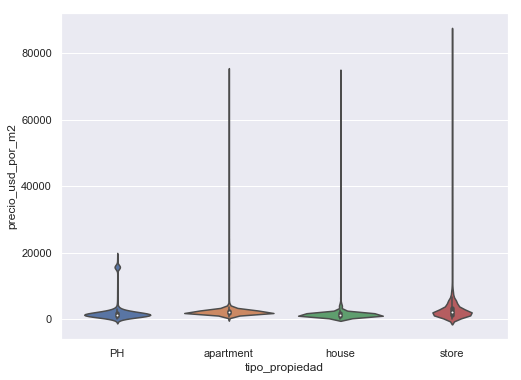

In [38]:
#Hago el gráfico
plt.figure(figsize=(8,6))
sns.violinplot(x="tipo_propiedad", y="precio_usd_por_m2", data=df3)

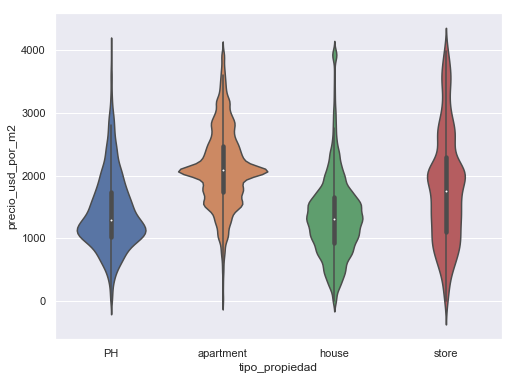

In [39]:
plt.figure(figsize=(8,6))
sns.violinplot(x="tipo_propiedad", y="precio_usd_por_m2", data=df3.loc[df3.precio_usd_por_m2<4000])